# Installation
## Prerequisites
To use our software, you must have **[Docker](https://docs.docker.com/engine/install)** (and **[Docker Compose](https://docs.docker.com/compose/install)**) installed on your system. The Docker Engine is compatible with many operating systems such as Linux, macOS, and Windows (via Docker Desktop). Follow the instructions at https://docs.docker.com/engine/install/ to acquire and install Docker. If you encounter an error stating "`docker compose is not a docker command`", follow the instructions at https://docs.docker.com/compose/install/ to install Docker Compose.

## Usage
1. Grab the latest `gg-framework.zip` from [releases](https://github.com/CorsairCoalition/docs/releases).
1. Extract the contents of the `gg-framework.zip` zip file and locate the folder named "gg-framework".
1. Open a terminal or command prompt and navigate to the "gg-framework" folder, e.g., using:
   ```sh
   $ cd path/to/gg-framework
   ```
1. From the "gg-framework" folder, execute the following command in the terminal 
   (**Note: Docker must be installed prior to using this command.**):
   ```sh
   $ docker compose up
   ```
   *(This command will start the Docker container hosting the GG framework components. You may see a series of warnings as Redis starts, but these can be safely ignored.)*
1. When you see "READY TO PLAY", continue to the next step.
1. Open a **separate** terminal/command prompt and navigate to the "gg-framework" folder. 
1. Execute the following command:
   ```sh
   $ docker compose run commander-cortex
   ```
    
The Commander Cortex UI should appear. You are now ready to use the pre-configured bot in the GG framework.

# Architecture Overview
The flowchart below shows how information flows between the modules within the GG framework. AI Agent logic is contained in the action recommenders and Commander Cortex. All communication passes through Redis, which also houses the historical gameplay data in a local key-value store. A Python notebook can use data from Redis and data available from the GIO servers to analyze bot performance (as demonstrated in the sections below).

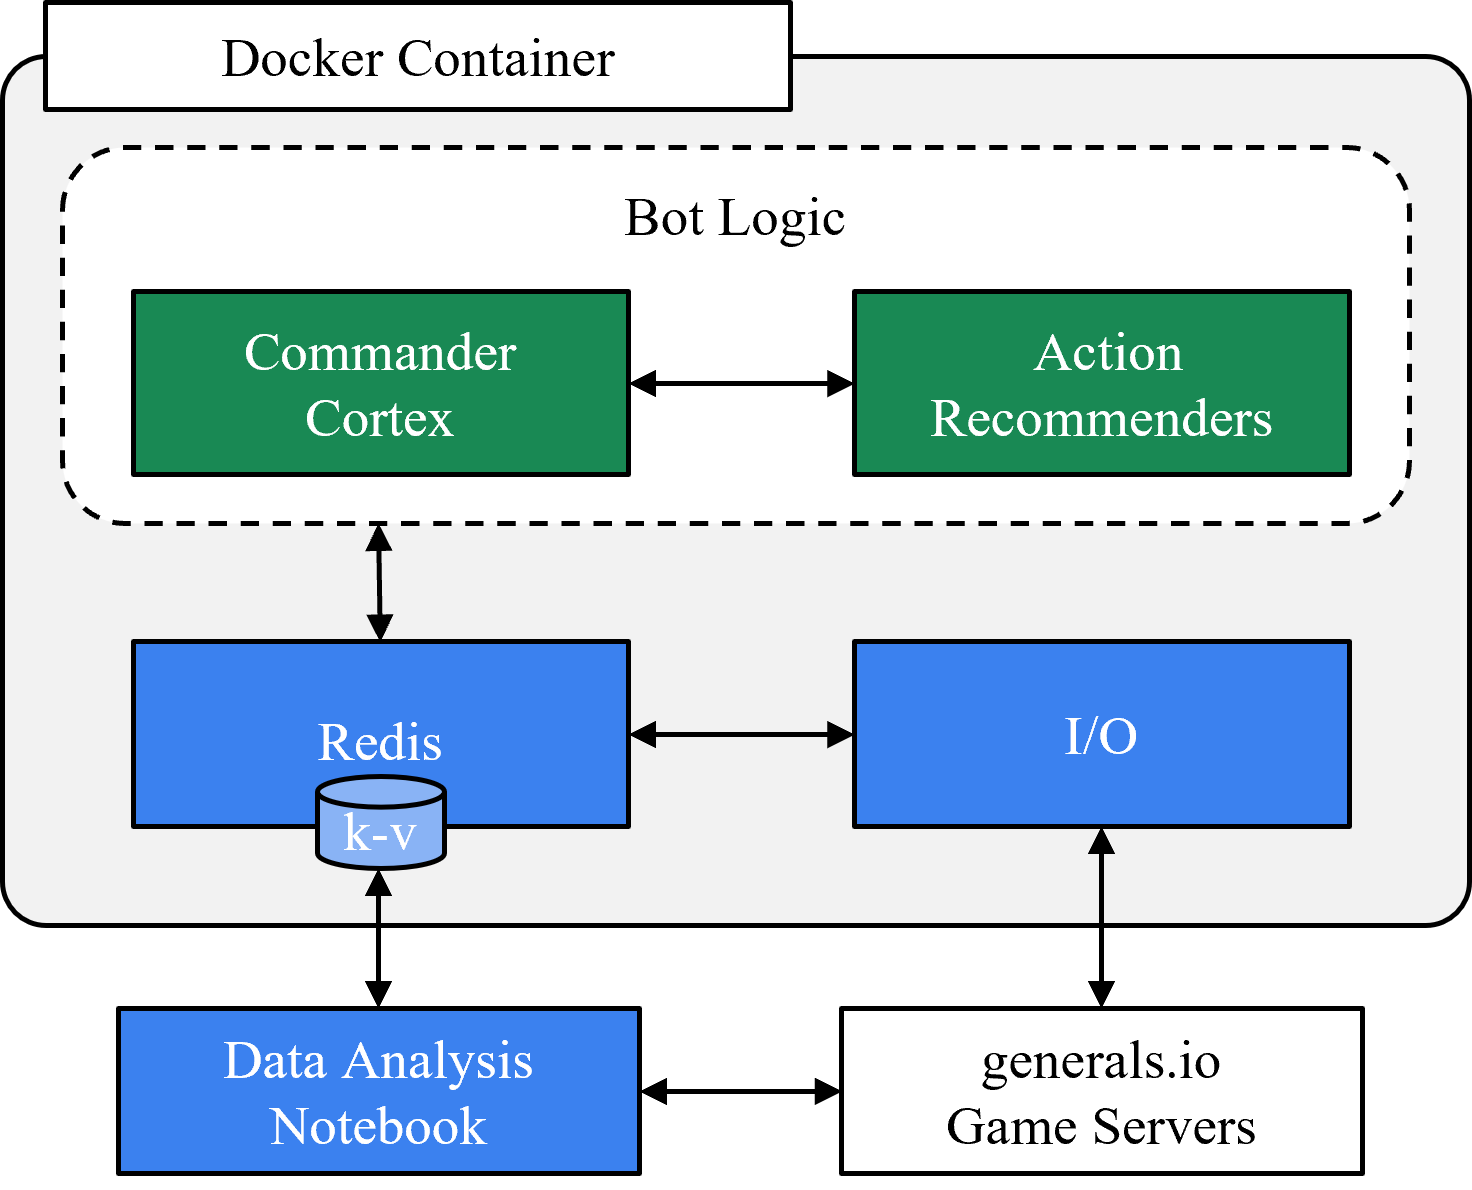


## Commander Cortex
The UI interface is designed with a command panel located at the top left corner, featuring options such as join game, leave game, and play $N$ games. Directly below this panel, users can find the recommendations generated by Commander Cortex. Beneath the recommendations, the interface displays the actions generated by ArmadaAssault. On the right side of the interface, there is a section that indicates the connection status to the generals.io server, as well as the current game status and relevant statistics.


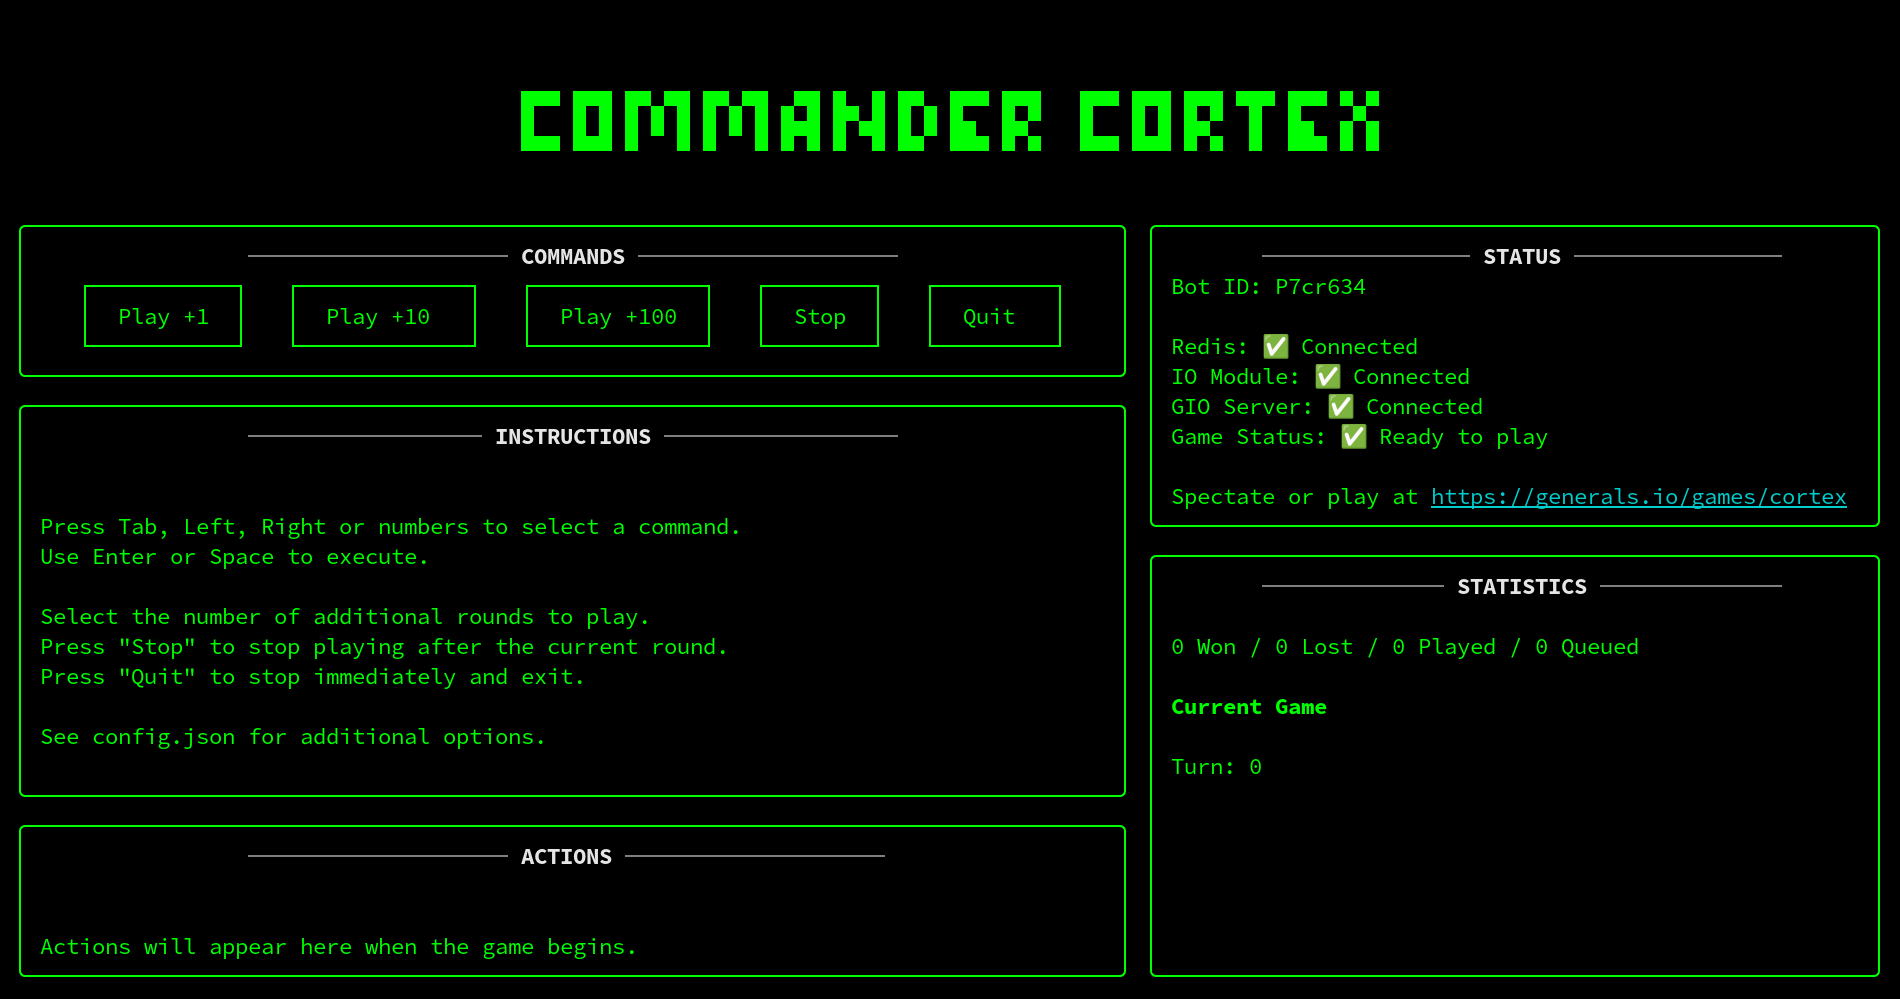


- STATUS block
  - **Bot ID** is used to record data in Redis. Yours will start with `cortex-`.
  - Spectate games live by visiting the URL. Be sure to **set your team to "Spectator"**
- COMMANDS block
  - **Play** +1, ..., Play +100 will queue the number of games you select. You can see the total number of queued games in the STATISTICS block.
  - **Stop** will clear the game queue
  - **Quit** will shut down Commander Cortex, the IO module, the connection to the GIO Server, and Redis.
- INSTRUCTIONS and ACTIONS blocks
  - Once a game begins, the INSTRUCTIONS block will be replaced with the RECOMMENDATIONS block showing the latest actions recommended by the action modules
  - The actions taken by your bot are displayed in the ACTIONS block
- STATISTICS
  - This block shows a running talley of games won, lost, played, and queued
  - During a game, the turn count, army sizes, and territory are shown
  - After a game, a URL is displayed allowing you to review an online replay of the match. These URLs are persistent and can be shared with others.
  - All data displayed here is also stored in Redis

# Data Analysis Demonstration
In this subsection, we will showcase various examples of data analysis techniques that can be applied to your imported gameplay data. Through practical examples and code snippets, we will cover a range of analysis tasks, including generating statistics, visualizations, and comparing different agent strategies. 

```{note}
----------------------------------------------------------------------
Note: Before continuing, use Commander Cortex to run a few games (3+).
----------------------------------------------------------------------
```


## Importing Gameplay Data

Several helper functions are included below to assist in capturing data from both the Redis key-value store and directly from the GIO servers. We use extensive caching to expedite the data loading process after the initial data pull from the GIO servers.

The process begins by obtaining a list of replay IDs (these are stored in Redis). These replay IDs are then used to fetch the corresponding game data from Redis, using the specific bot ID and replay ID combination. The retrieved data is then organized into a dataframe, which focuses on a particular bot ID and includes data from all replay IDs.

After creating the dataframe, the we demonstate the analysis process proceeds by analyzing the performance of the a bot across different quadrants, along with other simple evaluations.


In [ ]:
%pip install redis matplotlib numpy pandas

In [2]:
# packages we use in our analysis process
import redis
import json
import os
import urllib.request
import pandas as pd
from gior import gior

# The following (optional) packages were used to analyze the gameplay data. 
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# This code block contains the helper functions used to retrieve and format the gameplay datasets
def __separate_turn_by_turn_data__(scores_list, playerIndex):
    armies = []
    land = []
    armies_enemy = []
    land_enemy = []
    victory = False

    # Iterate through each turn's scores
    for turn_data in scores_list:
        turn_data_decoded = json.loads(turn_data.decode())

        # Iterate through each player's data in the turn
        for player_data in turn_data_decoded:
            if player_data["dead"]:
                victory = player_data["i"] != playerIndex

                # Append data to the respective lists based on player index
            if player_data["i"] == playerIndex:
                armies.append(player_data["total"])
                land.append(player_data["tiles"])
            else:
                armies_enemy.append(player_data["total"])
                land_enemy.append(player_data["tiles"])

                # Return the separated data
    return armies, land, armies_enemy, land_enemy, victory


def __fetch_from_redis__(botId, replay_id):

    FILE_REDIS = f"./cache/{botId}-{replay_id}.json"

    # Check local cache first
    if os.path.exists(FILE_REDIS):
        with open(FILE_REDIS, "r") as f:
            return json.load(f)

    # Fetch data from Redis
    response = r.hgetall(f"{botId}-{replay_id}")

    # If response is empty, return None
    if not response:
        return None

    data = {}

    # Iterate through the response items and decode and store the data
    for key, value in response.items():
        key_str = key.decode()
        data[key_str] = json.loads(value.decode())

    # Fetch scores and separate the turn-by-turn data
    scores_raw = r.lrange(f"{botId}-{replay_id}-scores", 0, -1)
    (
        data["armies_self"],
        data["land_self"],
        data["armies_enemy"],
        data["land_enemy"],
        data["victory"],
    ) = __separate_turn_by_turn_data__(scores_raw, data["playerIndex"])
    maxArmyOnTile = r.lrange(f"{botId}-{replay_id}-maxArmyOnTile", 0, -1)
    moveCount = r.lrange(f"{botId}-{replay_id}-moveCount", 0, -1)
    data["maxArmyOnTile"] = [json.loads(item.decode()) for item in maxArmyOnTile]
    data["moveCount"] = [json.loads(item.decode()) for item in moveCount]

    # Store the fetched data in the cache
    with open(FILE_REDIS, "w") as f:
        json.dump(data, f)

    return data


def __fetch_from_server__(replay_id):

    URL_NA = f"https://generalsio-replays-na.s3.amazonaws.com/{replay_id}.gior"
    URL_BOT = f"https://generalsio-replays-bot.s3.amazonaws.com/{replay_id}.gior"
    FILE_GIOR = f"./cache/gio-{replay_id}.gior"
    FILE_JSON = f"./cache/gio-{replay_id}.json"

    # If the JSON file exists, return its contents
    if os.path.isfile(FILE_JSON):
        with open(FILE_JSON, "r") as f:
            return json.load(f)

    # If the GIOR file does not exist, download it
    if not os.path.isfile(FILE_GIOR):
        try:
            try:
                # Attempt to download the GIOR file from the NA server URL
                urllib.request.urlretrieve(URL_NA, FILE_GIOR)
            except:
                # If the NA server download fails, try the BOT server URL
                urllib.request.urlretrieve(URL_BOT, FILE_GIOR)
        except:
            return None

            # If the GIOR file still doesn't exist, return None
    if not os.path.isfile(FILE_GIOR):
        return None

    data = gior.deserialize(FILE_GIOR)

    # Cache the data to the JSON file
    with open(FILE_JSON, "w") as f:
        json.dump(data, f)

    return data


def getQuadrant(location, width, height):
    x = location % width
    y = location // width

    quadrant = 0
    if y > height / 2:
        quadrant += 2
    if x > width / 2:
        quadrant += 1

    return quadrant

# This is the main function used to collect data from Redis and the GIO servers. 
# you can see we created custom columns in our dataset (e.g., using the getQuadrant 
# method). You can customize this to fit your data needs.
def fetch_data(botId, replay_id):

    data = __fetch_from_redis__(botId, replay_id)

    if data is None:
        return None

    serverData = __fetch_from_server__(replay_id)

    if serverData is None:
        return None

    # Update additional data in the fetched data
    data["enemyGeneralLocated"] = data["enemyGeneral"] != -1
    data["totalMoves"] = data["moveCount"][-1]
    data["maxArmyOnTileEver"] = max(data["maxArmyOnTile"])

    # Update enemy general information from the server data
    enemyIndex = 1 - data["playerIndex"]
    data["enemyGeneral"] = serverData["generals"][enemyIndex]

    # Calculate own and enemy quadrant based on general locations
    data["ownQuadrant"] = getQuadrant(data["ownGeneral"], data["width"], data["height"])
    data["enemyQuadrant"] = getQuadrant(data["enemyGeneral"], data["width"], data["height"])

    return data

# This function reads data from Redis and the GIO servers and returns it as a pandas dataframe.
def generateDataFrame(botId):

    # Retrieve all unique replay IDs from Redis
    replay_ids = [x.decode('utf-8').replace('"','') for x in r.lrange(botId + '-replays', 0, -1)]

    # Fetch data from for each replay_id and store in a list
    data_list = [fetch_data(botId, replay_id) for replay_id in replay_ids]

    # Convert the list of dictionaries to a pandas DataFrame
    df = pd.DataFrame(data_list)

    # We chose to drop the columns that we ignored during our analsis.
    df = df.drop(columns=[
        'chat_room', 'options', 'game_type', 'lights', 'swamps', 
        'playerColors', 'usernames', 'cities', 'ownTiles', 
        'enemyTiles', 'teams', 'armies', 'terrain', 'discoveredTiles'
        ], errors='ignore')

    return df

The following code block will create a reference to the Redis instance running in the Docker container. 

In [4]:
# Create a Redis client to connect to the local Redis server instance

r = redis.Redis(
    host="localhost",
    port=6379,
    db = 0
)

# Ensure cache directory exists
if not os.path.exists("./cache"):
    os.makedirs("./cache")

You can obtain your botId from Commander Cortex: It is an alphanumeric code printed in the upper right corner of the status block. It always starts with cortex-. This unique identifier is used to retrieve gameplay data from Redis and/or the GIO servers.

In [13]:
botId = 'cortex-796tP1U' # Update this to match the Bot ID in Commander Cortex!

df = generateDataFrame(botId)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   width                13 non-null     int64 
 1   playerIndex          13 non-null     int64 
 2   height               13 non-null     int64 
 3   size                 13 non-null     int64 
 4   replay_id            13 non-null     object
 5   turn                 13 non-null     int64 
 6   enemyGeneral         13 non-null     int64 
 7   ownGeneral           13 non-null     int64 
 8   armies_self          13 non-null     object
 9   land_self            13 non-null     object
 10  armies_enemy         13 non-null     object
 11  land_enemy           13 non-null     object
 12  victory              13 non-null     bool  
 13  maxArmyOnTile        13 non-null     object
 14  moveCount            13 non-null     object
 15  enemyGeneralLocated  13 non-null     bool  
 16  totalMoves

## Data Analysis Examples

In this section, we will provide an overview of the structure of the data collected using the GG framework and explain its key components. While the focus of this tutorial is not on performing extensive data analysis, understanding the structure of the data is crucial for effectively interpreting and utilizing it. By gaining insights into the data structure, you will be able to navigate and extract relevant information to evaluate your agent's performance and make informed decisions for further improvements.

### Summary Statistics
First, we'll compute some basic summary statistics and create simple visualizations.

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
width,13.0,20.000000,1.683251,18.0,18.0,20.0,22.0,22.0
playerIndex,13.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
height,13.0,19.692308,1.702186,18.0,18.0,19.0,21.0,22.0
size,13.0,392.692308,35.933700,324.0,378.0,396.0,399.0,484.0
turn,13.0,241.923077,114.917696,93.0,152.0,198.0,325.0,490.0
enemyGeneral,13.0,161.538462,143.937264,0.0,32.0,118.0,306.0,392.0
ownGeneral,13.0,263.923077,123.036215,1.0,176.0,275.0,362.0,426.0
totalMoves,13.0,526.769231,277.846527,168.0,295.0,460.0,754.0,952.0
maxArmyOnTileEver,13.0,55.538462,36.335509,14.0,22.0,54.0,71.0,135.0
ownQuadrant,13.0,1.769231,1.165751,0.0,1.0,2.0,3.0,3.0


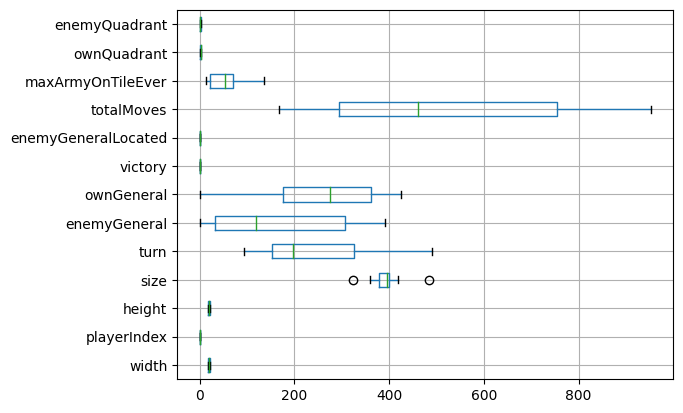

In [8]:
df.boxplot(vert=False)
plt.show()

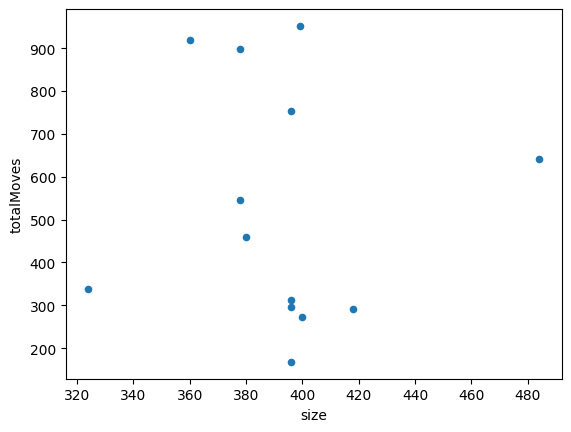

In [9]:
# One point in for each game played
df.plot(kind = 'scatter', x='size', y='totalMoves')
plt.show()

### Displaying turn-by-turn data
Several columns include turn-by-turn data (see Table 1 from the paper).
By unrolling these columns, we can analyze the trajectory of the capture data throughout a single game or across many games. The following plots show how this turn-by-turn data can be displayed quickly to gain interesting insights. These should serve as a starting point for further analysis.

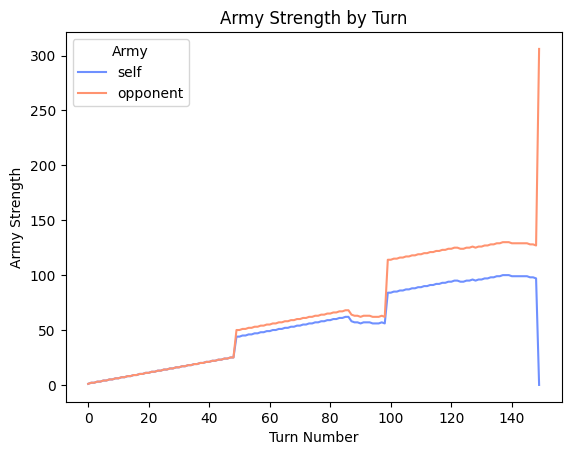

In [10]:
def compare_army_strengths_by_turn_single_plot(game_index):
    f, ax = plt.subplots()
    ax.plot(df['armies_self'][game_index], color = '#6F90FF',label='self')
    ax.plot(df['armies_enemy'][game_index], color = '#FF9370', label='opponent')
    ax.set_title('Army Strength by Turn')
    ax.set_xlabel('Turn Number')
    ax.set_ylabel('Army Strength')
    ax.legend(loc='upper left', title='Army')
    plt.show()

compare_army_strengths_by_turn_single_plot(game_index = 0)

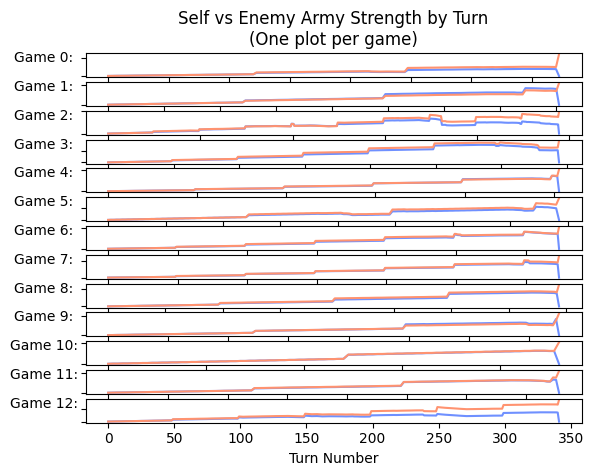

In [11]:
def compare_army_strengths_by_turn_separated():
    
    f, ax = plt.subplots(len(df))

    # Add one line plot for each game played
    for i in range(len(df)):
        ax[i].plot(df['armies_self'][i], color = '#6F90FF')
        ax[i].plot(df['armies_enemy'][i], color = '#FF9370')
        ax[i].set_yticklabels([]) # 
        ax[i].set_ylabel(f'Game {i}:            ', rotation=0)
    
    ax[0].set_title('Self vs Enemy Army Strength by Turn\n(One plot per game)')
    ax[len(df)-1].set_xlabel('Turn Number')
    plt.show()

compare_army_strengths_by_turn_separated()